### A simple fMRI analysis using SPM with nipype

Resources: 
     - https://miykael.github.io/nipype_tutorial/notebooks/introduction_showcase.html
     - https://pythonhosted.org/nipype/users/examples/fmri_spm_face.html
     - https://miykael.github.io/nipype_tutorial/notebooks/handson_analysis.html
     - https://pythonhosted.org/nipype/users/examples/fmri_spm_nested.html
     
     
A faire
 - utiliser MCR

In [1]:
from nipype import Node, Workflow
import os
import nipype.interfaces.matlab as mlab

Failed to import duecredit due to No module named 'duecredit'


In [2]:
# Set the way matlab should be called -- TODO
mlab.MatlabCommand.set_default_matlab_cmd("/Applications/MATLAB_R2017a.app/bin/matlab -nodesktop -nosplash")
# If SPM is not in your MATLAB path you should add it here
mlab.MatlabCommand.set_default_paths(os.path.join(os.getcwd(), '..', '..', 'spm8'))

In [3]:
from nipype.interfaces.spm import Segment, SliceTiming, Realign, Coregister, Normalize, Smooth
from nipype.interfaces.fsl import ExtractROI

In [4]:
# Defaults

tr = 2.5;
ta = 2.5;

num_img_stab = 2;

num_slices = 30

# FIS_UNITS = 'secs';

# FIS_CONDITIONS{1} = struct(...
#     'sessName', 'se_fingerfootlips',...
#     'condnames', {'finger'},...
#     'onsets', {(10:90:430) - NUM_IMG_STAB.nBeg*TR},...
#     'duration',{15});

# FIS_CONTRASTS{1} = struct(...
#     'contrastName', 'cn_figer', ...
#     'name', 'Motor finger: activations', ...
#     'coninfo', 'co_finger', ...
#     'negative', true, ...
#     'nameNegative', 'Motor finger: deactivations',...
#     'sessrep', 'none');

# INFORMED_BASIS_SET = false;

# FIS_THRESHOLDS{1} = struct('threshdesc', 'none', 'thresh', 0.001);

# GU_CONTRASTS{1} = struct(...
#     'contrastName', 'cn_figer', ...
#     'name', 'Motor finger: group activations', ...
#     'coninfo', 'co_finger', ...
#     'negative', true, ...
#     'nameNegative', 'Motor finger: deactivations',...
#     'sessrep', 'none');

# GU_THRESHOLDS{1} = struct('threshdesc', 'FWE', 'thresh', 0.05);

In [5]:
ds114 = os.path.join(os.getcwd(), '..', 'data', 'ds000114_R2.0.1')
base_output = os.path.join(os.getcwd(), '..', 'output', 'nipype')
preproc_folder =  'pre-processing'

### anatomical MRI preprocessing

In [6]:
segment = Node(Segment(save_bias_corrected=True), name="segment")

### fMRI preprocessing

In [7]:
TR=tr

# Slice order must start from 1 not zero (otherwise we get a Matlab error)

slicetiming = Node(SliceTiming(time_repetition=TR,
                             time_acquisition=TR - TR / float(num_slices),
                             num_slices = num_slices,
                             slice_order = list(range(1, num_slices+1, 2)) + list(range(2, num_slices+1, 2)), # TODO
                             ref_slice = int(num_slices / 2)), name="slicetiming")
realign = Node(Realign(), name = 'realign')
coreg = Node(Coregister(), name = 'coreg')
norm = Node(Normalize(), name = 'norm')
norm.inputs.jobtype = "write"
norm_anat = Node(Normalize(), name = 'norm_anat')
norm_anat.inputs.jobtype = "write"
smooth = Node(Smooth(), name = 'smooth')


In [8]:
len(list(range(0, num_slices, 2)) + list(range(1, num_slices, 2)))


30

In [9]:
from nipype.algorithms.misc import Gunzip

gunzip = Node(Gunzip(), name='gunzip')

In [10]:
# slicetiming.inputs.in_files = [one_fmri_file]
# segment.inputs.data = one_anat_file



In [11]:
# list of session identifiers
task_list = ['fingerfootlips']

In [59]:
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink


# list of subject identifiers
# subject_list = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']
subject_list = ['01', '02']

# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id', 'task_name']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('task_name', task_list)]

# Skip dummy scans
extract = Node(ExtractROI(t_min=num_img_stab, t_size=-1, output_type='NIFTI'),
               name="extract")

# SelectFiles - to grab the data (alternativ to DataGrabber)
anat_file = os.path.join('sub-{subject_id}', 'ses-test', 'anat', 'sub-{subject_id}_ses-test_t1w.nii.gz')
func_file = os.path.join('sub-{subject_id}', 'ses-test', 'func',
                'sub-{subject_id}_ses-test_task-{task_name}_bold.nii.gz')

templates = {'anat': anat_file,
             'func': func_file}
selectfiles = Node(SelectFiles(templates,
                               base_directory=ds114),
                   name="selectfiles")

# datasink = Node(DataSink(base_directory=base_output,
#                          container=preproc_folder,
#                          parameterization=False),
#                 name="datasink")

# ## Use the following substitutions for the DataSink output
# substitutions = [('_subj_id_', 'su_')]
# datasink.inputs.substitutions = substitutions

181122-18:06:03,338 nipype.workflow INFO:
	 Generated workflow graph: /Users/camaumet/Softs/fmri_example_pipelines/scripts/../output/nipype/preproc/graph.png (graph2use=colored, simple_form=True).


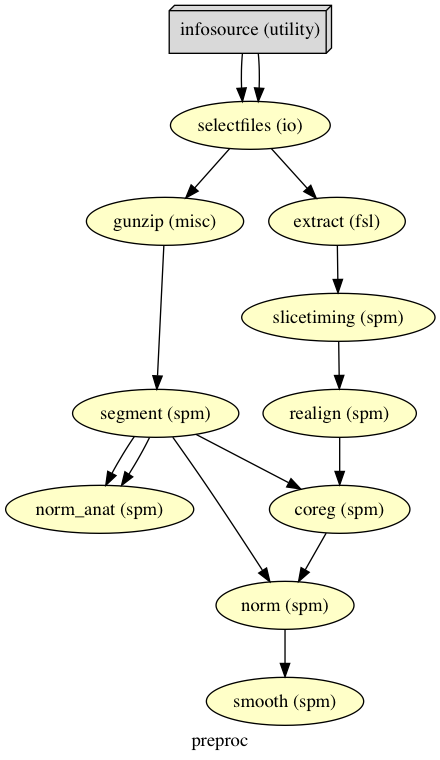

In [60]:
preproc = Workflow(name='preproc')
preproc.base_dir = os.path.join(base_output)

preproc.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                            ('task_name', 'task_name')]),
                 (selectfiles, extract, [('func', 'in_file')]),
                 (extract, slicetiming, [('roi_file', 'in_files')]),
                 (slicetiming, realign, [('timecorrected_files', 'in_files')]),
                 (realign, coreg, [('mean_image', 'source')]),
                 (selectfiles, gunzip, [('anat', 'in_file')]),
                 (gunzip, segment, [('out_file', 'data')]),
                 (segment, coreg, [('bias_corrected_image', 'target')]),
                 (coreg, norm, [('coregistered_source', 'source')]),
                 (norm, smooth, [('normalized_source', 'in_files')]),
                 (segment, norm, [('transformation_mat', 'parameter_file')]),
                 (segment, norm_anat, [('bias_corrected_image', 'source'),
                                       ('transformation_mat', 'parameter_file')])])

preproc.write_graph(graph2use='colored', format='png', simple_form=True)

# # Save outputs
# preproc.connect([(slicetiming, datasink, [('timecorrected_files', 'functional.@slicetimed')]),
#                  (realign, datasink, [('mean_image', 'functional.@realigned_mean'),
#                                       ('realigned_files', 'functional.@realigned'),
#                                       ('realignment_parameters', 'functional.@realigned_param')]),
#                  (coreg, datasink, [('coregistered_files', 'functional.@coreg')]),
#                  (norm, datasink, [('normalized_source', 'functional.@norm')]),
#                  (norm_anat, datasink, [('normalized_source', 'anat.@norm')]),
#                  (segment, datasink, [('bias_corrected_image', 'anat.@t1'),
#                                       ('native_gm_image', 'anat.@gm'),
#                                       ('native_wm_image', 'anat.@wm'),
#                                       ('native_csf_image', 'anat.@csf')])
#                  ])



# Visualize the graph
from IPython.display import Image
Image(filename=os.path.join(preproc.base_dir, 'preproc', 'graph.png'))



In [61]:
# preproc.run('MultiProc', plugin_args={'n_procs': 1})

181122-18:06:04,446 nipype.workflow INFO:
	 Workflow preproc settings: ['check', 'execution', 'logging', 'monitoring']
181122-18:06:04,545 nipype.workflow INFO:
	 Running in parallel.
181122-18:06:04,549 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 1/1.
181122-18:06:04,630 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selectfiles" in "/Users/camaumet/Softs/fmri_example_pipelines/output/nipype/preproc/_subject_id_02_task_name_fingerfootlips/selectfiles".
181122-18:06:04,647 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
181122-18:06:04,673 nipype.workflow INFO:
	 [Node] Finished "preproc.selectfiles".
181122-18:06:06,555 nipype.workflow INFO:
	 [Job 0] Completed (preproc.selectfiles).
181122-18:06:06,561 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 3 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 1/1.
181122-18:06:06,657 nipype.workflow INFO:

KeyboardInterrupt: 

### L1 stat analysis

181122-18:06:24,60 nipype.workflow INFO:
	 Generated workflow graph: /Users/camaumet/Softs/fmri_example_pipelines/scripts/../output/nipype/analysis/graph.png (graph2use=colored, simple_form=True).


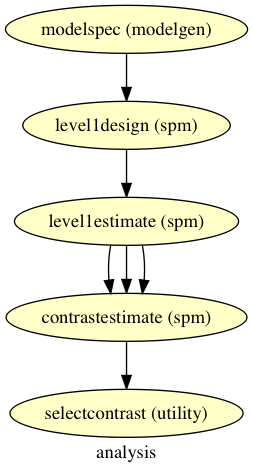

In [62]:
from nipype.interfaces import spm as spm          # spm -- TODO harmonize with top imports
from nipype.pipeline import engine as pe          # pypeline engine
from nipype.algorithms import modelgen as model   # model specification
from nipype.interfaces import utility as niu      # utility

l1analysis = pe.Workflow(name='analysis')

l1analysis.base_dir = os.path.join(base_output)

modelspec = pe.Node(model.SpecifySPMModel(), name="modelspec")
# modelspec.inputs.concatenate_runs = True
modelspec.inputs.concatenate_runs = False
modelspec.inputs.input_units = 'secs'
modelspec.inputs.output_units = 'secs'
modelspec.inputs.time_repetition = tr
modelspec.inputs.high_pass_filter_cutoff = 120

level1design = pe.Node(spm.Level1Design(), name="level1design")
level1design.inputs.bases = {'hrf': {'derivs': [0, 0]}}

level1estimate = pe.Node(spm.EstimateModel(), name="level1estimate")
level1estimate.inputs.estimation_method = {'Classical': 1}

contrastestimate = pe.Node(spm.EstimateContrast(), name="contrastestimate")

selectcontrast = pe.Node(niu.Select(), name="selectcontrast")

l1analysis.connect([(modelspec, level1design, [('session_info', 'session_info')]),
                    (level1design, level1estimate, [('spm_mat_file', 'spm_mat_file')]),
                    (level1estimate, contrastestimate, [('spm_mat_file', 'spm_mat_file'),
                                                        ('beta_images', 'beta_images'),
                                                        ('residual_image', 'residual_image')]),
                    (contrastestimate, selectcontrast, [('spmT_images', 'inlist')])
                    ])

l1analysis.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=os.path.join(l1analysis.base_dir, 'analysis', 'graph.png'))


181122-18:06:28,164 nipype.workflow INFO:
	 Generated workflow graph: /Users/camaumet/Softs/fmri_example_pipelines/scripts/../output/nipype/firstlevel/graph.png (graph2use=colored, simple_form=True).


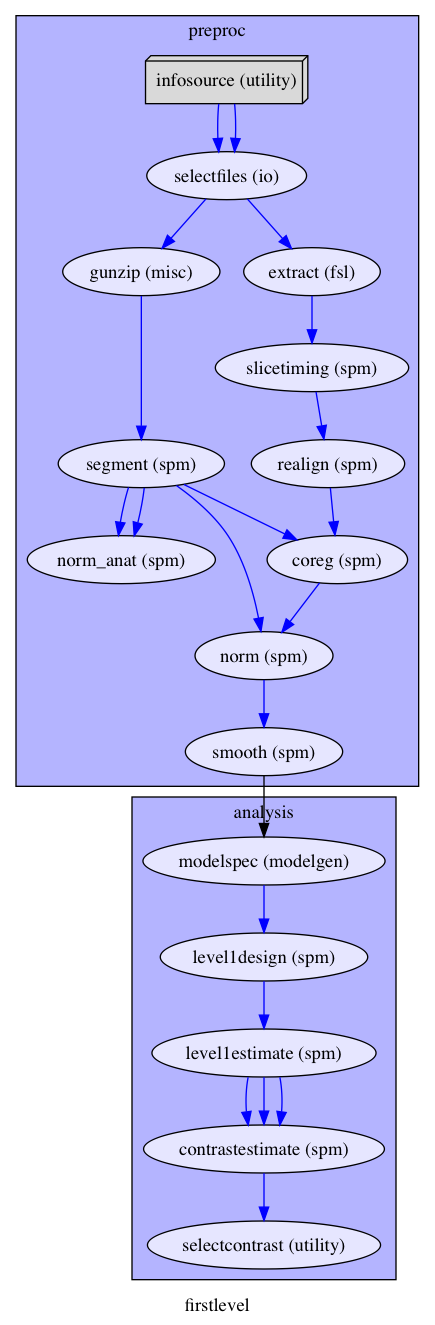

In [63]:
l1pipeline = pe.Workflow(name='firstlevel')

l1pipeline.base_dir = os.path.join(base_output)

l1pipeline.connect([(preproc, l1analysis, [
#     ('realign.realignment_parameters', 'modelspec.realignment_parameters'),
    ('smooth.smoothed_files', 'modelspec.functional_runs')]),
                    ])

l1pipeline.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=os.path.join(l1pipeline.base_dir, 'firstlevel', 'graph.png'))

In [64]:
# l1pipeline.run('MultiProc', plugin_args={'n_procs': 1})

In [73]:
def subjectinfo(subject_id):
    from nipype.interfaces.base import Bunch
    from copy import deepcopy
    print("Subject ID: %s\n" % str(subject_id))
    output = []
    cond_names = ['finger'] # TODO load from params
    for r in range(4):
        onsets = [list(range(10, 430, 90))] # TODO load from params
        output.insert(r,
                      Bunch(conditions=cond_names,
                            onsets=deepcopy(onsets),
                            durations=[[15] for s in cond_names], # TODO load from params
                            amplitudes=None,
                            tmod=None,
                            pmod=None,
                            regressor_names=None,
                            regressors=None))
    return output

In [74]:
# GU_CONTRASTS{1} = struct(...
#     'contrastName', 'cn_figer', ...
#     'name', 'Motor finger: group activations', ...
#     'coninfo', 'co_finger', ...
#     'negative', true, ...
#     'nameNegative', 'Motor finger: deactivations',...
#     'sessrep', 'none');

# GU_THRESHOLDS{1} = struct('threshdesc', 'FWE', 'thresh', 0.05);


cont1 = ('Motor finger: group activations', 'T', ['finger'], [1]) # TODO load from params
cont2 = ('Motor finger: group deactivations', 'T', ['finger'], [-1])# TODO load from params
contrasts = [cont1, cont2]

# set up node specific inputs
modelspecref = l1pipeline.inputs.analysis.modelspec
modelspecref.input_units = 'secs'
modelspecref.output_units = 'secs'
modelspecref.time_repetition = 3.
modelspecref.high_pass_filter_cutoff = 120

l1designref = l1pipeline.inputs.analysis.level1design
l1designref.timing_units = modelspecref.output_units
l1designref.interscan_interval = modelspecref.time_repetition


l1pipeline.inputs.analysis.contrastestimate.contrasts = contrasts


# Iterate over each contrast and create report images.
selectcontrast.iterables = ('index', [[i] for i in range(len(contrasts))])

181122-18:08:21,484 nipype.workflow INFO:
	 Generated workflow graph: /Users/camaumet/Softs/fmri_example_pipelines/output/nipype/level1/graph.png (graph2use=colored, simple_form=True).


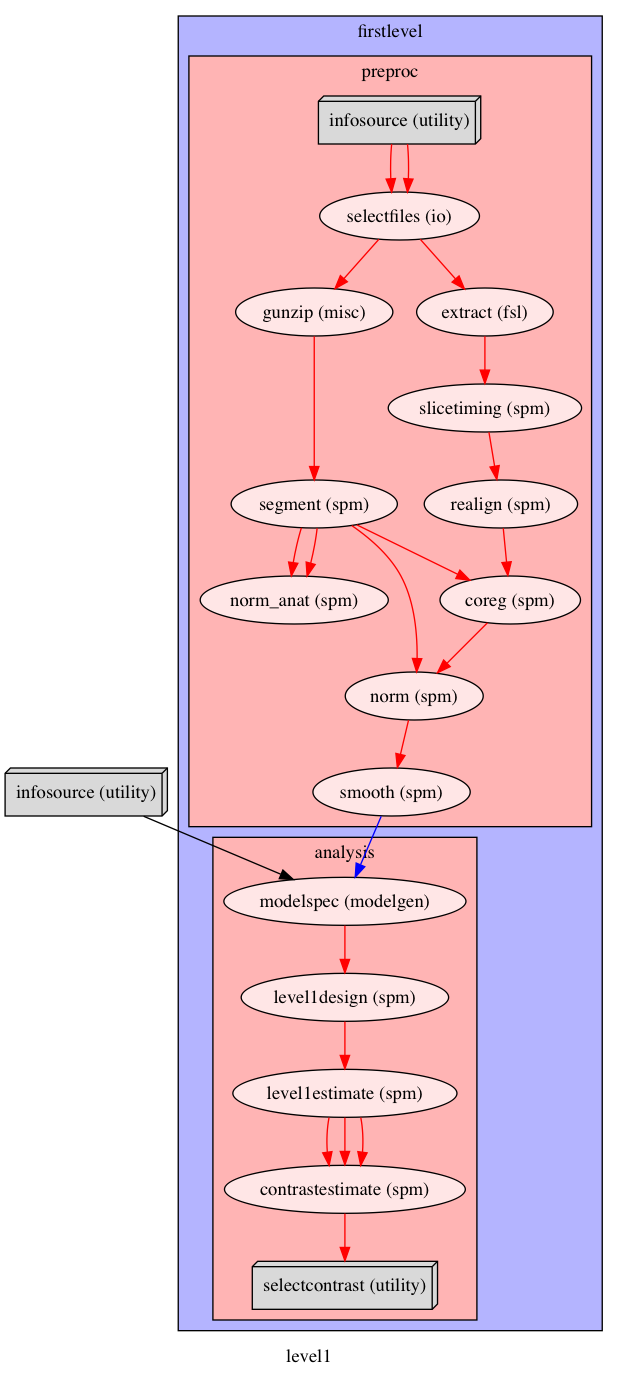

In [75]:
level1 = pe.Workflow(name="level1")
level1.base_dir = os.path.abspath(base_output)

level1.connect([
                (infosource, l1pipeline, [(('subject_id', subjectinfo),
                                           'analysis.modelspec.subject_info')]),
                ])

level1.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=os.path.join(level1.base_dir, 'level1', 'graph.png'))


In [76]:
level1.run('MultiProc', plugin_args={'n_procs': 1})

181122-18:08:22,364 nipype.workflow INFO:
	 Workflow level1 settings: ['check', 'execution', 'logging', 'monitoring']
Subject ID: 02

Subject ID: 01

181122-18:08:22,424 nipype.workflow INFO:
	 Running in parallel.
181122-18:08:22,430 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 1/1.
181122-18:08:22,520 nipype.workflow INFO:
	 [Node] Setting-up "level1.firstlevel.preproc.selectfiles" in "/Users/camaumet/Softs/fmri_example_pipelines/output/nipype/level1/firstlevel/preproc/_subject_id_02_task_name_fingerfootlips/selectfiles".
181122-18:08:22,537 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
181122-18:08:22,559 nipype.workflow INFO:
	 [Node] Finished "level1.firstlevel.preproc.selectfiles".
181122-18:08:24,431 nipype.workflow INFO:
	 [Job 0] Completed (level1.firstlevel.preproc.selectfiles).
181122-18:08:24,437 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 3 job

181122-18:16:42,966 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 1/1.
181122-18:16:43,23 nipype.workflow INFO:
	 [Node] Setting-up "level1.firstlevel.preproc.smooth" in "/Users/camaumet/Softs/fmri_example_pipelines/output/nipype/level1/firstlevel/preproc/_subject_id_02_task_name_fingerfootlips/smooth".
181122-18:16:43,34 nipype.workflow INFO:
	 [Node] Running "smooth" ("nipype.interfaces.spm.preprocess.Smooth")
181122-18:16:44,966 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 1 jobs ready. Free memory (GB): 14.20/14.40, Free processors: 0/1.
                     Currently running:
                       * level1.firstlevel.preproc.smooth
181122-18:17:55,457 nipype.workflow INFO:
	 [Node] Finished "level1.firstlevel.preproc.smooth".
181122-18:17:57,53 nipype.workflow INFO:
	 [Job 9] Completed (level1.firstlevel.preproc.smooth).
181122-18:17:57,57 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 

	 [Node] Setting-up "level1.firstlevel.preproc.slicetiming" in "/Users/camaumet/Softs/fmri_example_pipelines/output/nipype/level1/firstlevel/preproc/_subject_id_01_task_name_fingerfootlips/slicetiming".
181122-18:22:15,412 nipype.workflow INFO:
	 [Node] Running "slicetiming" ("nipype.interfaces.spm.preprocess.SliceTiming")
181122-18:22:17,346 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 14.20/14.40, Free processors: 0/1.
                     Currently running:
                       * level1.firstlevel.preproc.slicetiming
181122-18:22:57,713 nipype.workflow INFO:
	 [Node] Finished "level1.firstlevel.preproc.slicetiming".
181122-18:22:59,383 nipype.workflow INFO:
	 [Job 21] Completed (level1.firstlevel.preproc.slicetiming).
181122-18:22:59,386 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 1/1.
181122-18:22:59,438 nipype.workflow INFO:
	 [Node] Setting-up "level1.firstleve

RuntimeError: Workflow did not execute cleanly. Check log for details